# Trainen van een simpel TensorFlow Lite model voor microcontrollers

Deze notebook demonstreert het proces voor het trainen van een `2.5 kB` model met TensorFlow en het converteren voor gebruik met TensorFlow Lite voor microcontrollers.

Deep learning netwerken leren patronen in onderliggende data te modelleren. Hier gaan we een netwerk trainen om gegevens te modelleren die zijn gegenereerd door een sinus functie. Dit zal resulteren in een model dat een waarde, `x`, kan aannemen en zijn sinus, `y`, kan voorspellen.

Deze notebook is gebaseerd op de originele [hello world demo van TensorFlow Lite](https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb).

## In een virtuele environment

Je kan deze notebook ook runnen op een computer in een virtuele python environment aan de hand van `conda`.

```bash
conda create -n ts-flow python=3.9
conda activate ts-flow
```

Vergeet in VSCode dan niet om je kernel correct te zetten.

## Configure Defaults

In [22]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Opzetten van omgeving

Installeren van de nodige libraries. Hier in commentaar gezet omdat dit reeds voor jullie is gedaan. Dit duurt ook vrij lang.


In [ ]:
# ! pip install tensorflow==2.4.0
# ! pip install pandas
# ! pip install matplotlib

Importeren van de nodige libraries.
- **tensorflow:** open source machine learning library
- **keras:** high-level API rond tensorflow voor deep learning
- **numpy:** wiskundige library
- **panda:** data manipulatie library
- **matplotlib:** library voor grafieken
- **math:** wiskundige library

In [23]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

## Maken van een simpele dataset

In deze stap gaan we een artificiële dataset generen. In de realiteit zouden we dit bv. kunnen opmeten met een automatische meetopstelling.

In de praktijk is het model maar zo goed als de originele dataset waarmee we het trainen. Vandaar dat het in de praktijk heel belangrijk is om een goede dataset te hebben.

### 1. Genereren van de data

In onderstaande code genereren we een random set van `x` waarden. Voor elke `x` waarde berekenen we dan de `sinus(x)`, welke dan onze `y` waarden worden.

Het resultaat geven we terug in een grafiek.

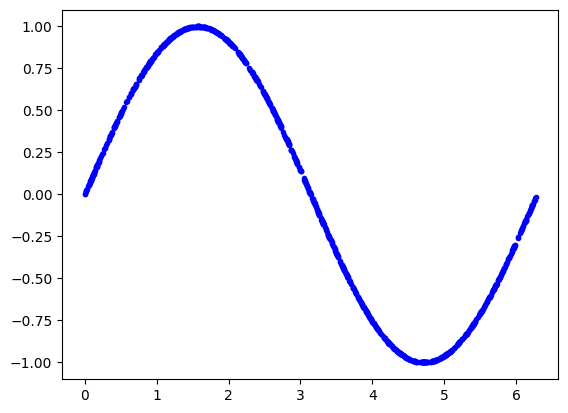

In [24]:
# Number of sample datapoints
SAMPLES = 1000

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values).astype(np.float32)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

### 2. Toevoegen van ruis

Onze data werd rechtstreeks gegeneerd door de sinus functie en heeft daarom een mooie vorm.

Machine learning modellen zijn echter goed in het extraheren van de onderliggende betekenis van rommelige data uit de echte wereld. Om dit aan te tonen, kunnen we wat ruis aan onze data toevoegen om een iets realistischere situatie te benaderen.

Onderstaande code voegt wat willekeurige ruis toe aan elke waarde. Het resultaat wordt opnieuw in een grafiek weergegeven.

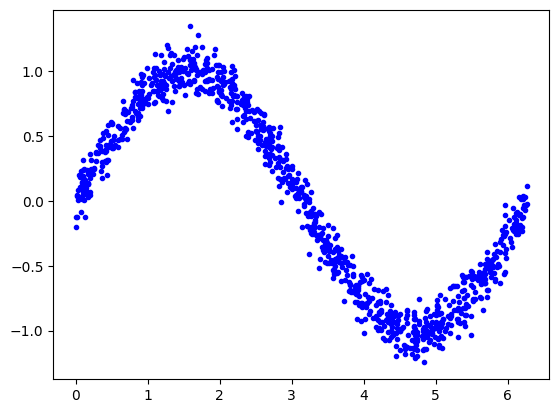

In [25]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

### 3. Splits de data

De dataset die we nu hebben gemaakt is een benadering van een realistische dataset. Deze waarden gaan we nu gebruiken om ons model te trainen.

Om de nauwkeurigheid van het model dat we trainen te evalueren, moeten we de voorspellingen vergelijken met echte gegevens en controleren hoe goed ze overeenkomen. Deze evaluatie vindt plaats tijdens de training (waar dit **validatie** wordt genoemd) en na de training (ook wel **testen** genoemd). In beide gevallen is het belangrijk dat we nieuwe gegevens gebruiken die nog niet zijn gebruikt om het model te trainen.

We dienen onze dataset dus op te splitsen in 3 groepen:

1. **Trainingsdata:** 60% (het grootste aantal gebruiken we om het model te trainen)
2. **Validatie:** 20% (wordt gebruikt tijdens het trainen om model bij te sturen)
3. **Testen:** 20% (wordt gebruikt na het trainen om te kijken hoe goed het model werkt)

Onderstaande code zal onze originele dataset opsplitsen in deze verschillende sets en grafisch weergeven met elk hun eigen kleur.

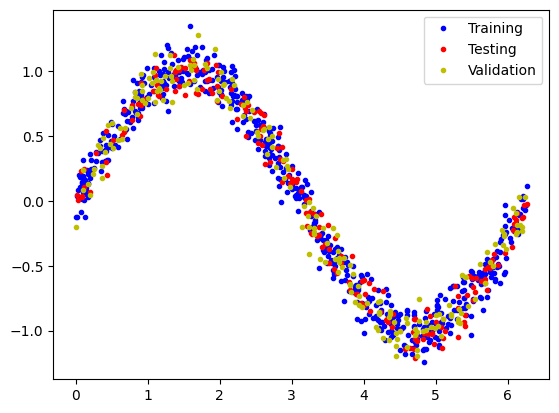

In [26]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Training")
plt.plot(x_test, y_test, 'r.', label="Testing")
plt.plot(x_validate, y_validate, 'y.', label="Validation")
plt.legend()
plt.show()


## Training

Nu onze dataset klaar is, kunnen we starten met het maken van een neuraal netwerk om het vervolgens te trainen met de data die we uit vorige stap hebben.

### 1. Creëren van een Model

In deze stap gaan we een simpel neural netwerk model bouwen dat een input waarde (hier in ons geval de `x` parameter) neemt en dit gebruikt om de bijhorende sinus waarde te voorspellen (hier voorgesteld door `y`).

In dit geval hebben we te maken met **regressie**. Regressie is een statistische methode die in AI wordt gebruikt om de relatie tussen een afhankelijke variabele en een of meer onafhankelijke variabelen te modelleren. Het wordt gebruikt voor het voorspellen van continue waarden (reële getallen) voor een bepaalde invoer. Het model wordt vervolgens gebruikt om voorspellingen te doen op nieuwe, ongeziene gegevens.

TODO: Is onderstaande correct?

Het neuraal netwerk zal bestaan uit volgende onderdelen:

1. Een input die onze `x` waarde zal bevatten
2. Een **hidden layer** met 8 **neuronen**
    - Op basis van deze input zal elk neuron _geactiveerd_ worden met een bepaalde waarde en dit op basis van zijn interne parameters (_gewicht_ (_weight_) en _offset_ (_bias_)). De activeringsgraad van een neuron wordt uitgedrukt als een getal.
3. Een **output** layer die het resultaat van de 8 neuronen zal samennemen om een voorspelling te maken van de `y` waarde
    - De activeringsnummers van onze verborgen layer zullen als invoer worden gebruikt voor onze output layer, die een enkele neuron is. Het zal zijn eigen gewichten en offset toepassen op deze invoer en zijn eigen activering berekenen, die zal resulteren in een `y`-waarde.

<!-- De input is hier niet echt een layer maar eerder een input object. Meer info hier: [https://www.tensorflow.org/guide/keras/sequential_model](https://www.tensorflow.org/guide/keras/sequential_model). -->

![Neural Network](./img/neural_network.jpg)

TODO: Update drawing above

De code hieronder maakt een model zoals we hierboven hebben beschreven. Eens dit samengesteld is compileren we dit zodat het klaar is om te trainen.

Als output zie je een klein overzicht van je gemaakt model.

In [40]:
# We'll use Keras to create a simple model architecture
model_1 = tf.keras.Sequential(name="basic-model")

# First layer takes a scalar input and feeds it through 8 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(keras.layers.Dense(8, activation='relu', input_shape=(1,), name="hidden-layer"))

# Final layer is a single neuron, since we want to output a single value
model_1.add(keras.layers.Dense(1, name="output-layer"))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Output some information about the model
model_1.summary()

Model: "basic-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden-layer (Dense)        (None, 8)                 16        
                                                                 
 output-layer (Dense)        (None, 1)                 9         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


### 2. Trainen van het Model

Zodra we het model hebben gedefinieerd, kunnen we onze gegevens gebruiken om het te **trainen**. Training bestaat uit aanvoeren van een `x`-waarde aan het neurale netwerk, controleren hoe ver de output van het netwerk afwijkt van de verwachte `y`-waarde en het aanpassen van de gewichten en offsets van de neuronen, zodat de kans groter is dat de output de volgende keer correct is.

Training voert dit proces meerdere keren uit op de volledige dataset en elke volledige doorloop wordt een **epoch** genoemd. Het aantal epochs dat tijdens de training moet worden uitgevoerd, is een parameter die we kunnen instellen.

Tijdens elke epoch, wordt een deel van de dataset door het netwerk gestuurd. Deze subset van de originele training set noemen we een **batch**. Elke batch wordt door het netwerk gestuurd en de bijhorende output van elke input wordt bijgehouden. De correctheid van de outputs wordt vervolgens opgemeten en geaggregeerd. Op basis hiervan worden dan de gewichten en offset van het netwerk aangepast.

TODO: Figuur van trainingsproces?

De grootte van de batch kan naar voorkeur ook worden aangepast.

Onderstaande code gebruikt de waarden `x` en `y` uit onze training set om het model te trainen. Het draait voor 500 _epochs_, met 64 stukjes data in elke _batch_. We geven ook enkele gegevens door voor _validatie_. Zoals je zult zien als je code uitvoert is dit een vrij intensief proces. Het trainen van een AI model vraagt heel wat rekenkracht, en dit is een super simpel model.

In [41]:
# Train the model on our training data while validating on our validation set
history_1 = model_1.fit(x_train, y_train, epochs=500, batch_size=64,
                        validation_data=(x_validate, y_validate))

Epoch 1/500
10/10 [==============================] - 1s 18ms/step - loss: 0.4307 - mae: 0.5705 - val_loss: 0.4447 - val_mae: 0.5789
Epoch 2/500
10/10 [==============================] - 0s 7ms/step - loss: 0.4213 - mae: 0.5624 - val_loss: 0.4364 - val_mae: 0.5730
Epoch 3/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4132 - mae: 0.5553 - val_loss: 0.4278 - val_mae: 0.5667
Epoch 4/500
10/10 [==============================] - 0s 7ms/step - loss: 0.4053 - mae: 0.5483 - val_loss: 0.4200 - val_mae: 0.5610
Epoch 5/500
10/10 [==============================] - 0s 6ms/step - loss: 0.3981 - mae: 0.5419 - val_loss: 0.4124 - val_mae: 0.5556
Epoch 6/500
10/10 [==============================] - 0s 9ms/step - loss: 0.3909 - mae: 0.5359 - val_loss: 0.4050 - val_mae: 0.5507
Epoch 7/500
10/10 [==============================] - 0s 6ms/step - loss: 0.3840 - mae: 0.5306 - val_loss: 0.3979 - val_mae: 0.5461
Epoch 8/500
10/10 [==============================] - 0s 7ms/step - loss: 0.3771 - 

### 3. Analyse van de statistieken

In dit deel gaan we dieper in op de prestaties van ons getrained model.

**1. Loss (of gemiddelde kwadratische fout)**
<!-- Loss (or Mean Squared Error) -->

Tijdens het trainen, wordt de prestatie van het model constant gemeten op basis van de trainings data en de validatie data (aparte data set). Het trainingsproces voorziet een volledige historiek van de prestaties van het model tijdens het trainen zodat we de evolutie van het trainingsproces achteraf kunnen analyseren.

In volgende secties gaan we hier dieper op in.

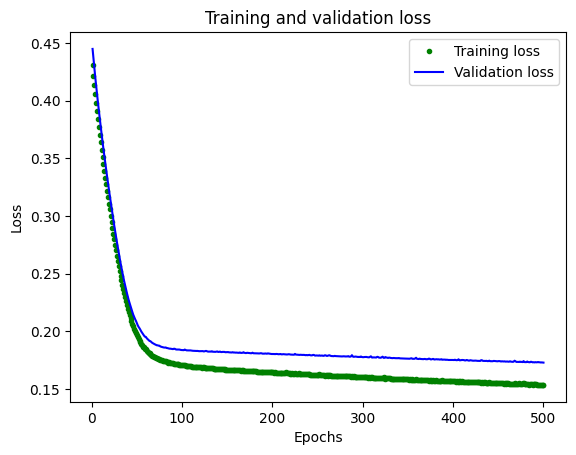

In [42]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

De grafiek toont de **loss** (verlies). Dit is het verschil tussen de door het model voorspelde waarde en de eigenlijk data en dit voor elke epoch. De `loss`-waarde wordt hierbij per epoch bepaald door de gemiddelde kwadratische fout te berekenen (er zijn ook nog andere manieren).

Merk op dat er een `loss` wordt getoond voor zowel de originele training set als voor de validatie set.

We zien in de grafiek dat de `loss` snel afneemt over de eerste 25 epochs, waarna deze begint te stabiliseren. Dit betekent dat het model in de eerste 25 epochs sterk verbetert en nauwkeurigere voorspellingen produceert.

Ons doel is om te stoppen met trainen wanneer het niet meer verbeterd of wanneer de `training loss` lager wordt dan de `validation loss`, in welk geval het model geleerd heeft om de trainings data zo goed te voorspellen dat het niet meer beter kan met nieuwe data.

Om te kijken waar we best stoppen met trainen, kunnen we best even inzoomen op de grafiek op het gedeelte **na de eerste 50 epochs**.

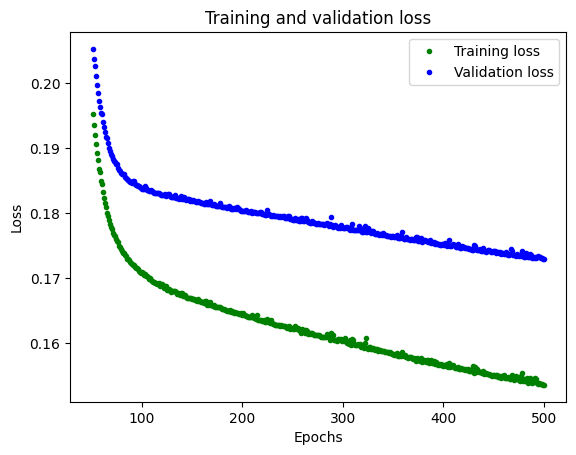

In [43]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Uit de grafiek kunnen we concluderen dat de `loss` daalt tot ongeveer 200 epochs. Vanaf daar begint het te stabiliseren. Dit betekent dat we eigenlijk **na 200 epochs kunnen stoppen** met het trainen van ons model.

We kunnen echter ook zien dat de laagste `loss` rond de `0.155` ligt. Dit betekent dat de voorspellingen van ons netwerk gemiddeld `~15%` afwijken. Bovendien springen de `validation loss` waarden veel rond en zijn ze soms zelfs hoger.

TODO: We kunnen echter ook zien dat de laagste `loss` rond de `0.145` ligt. Dit betekent dat de voorspellingen van ons netwerk gemiddeld `~14%` afwijken. Daarnaast zien we dat de `validation loss` waarden een stuk hoger liggen, namelijk rond de `0.165`.

**2. Gemiddelde absolute fout**
<!-- Mean Absolute Error -->

Om meer inzicht te krijgen in de prestaties van ons model kunnen we wat meer gegevens in een grafiek plaatsen. Deze keer zullen we de gemiddelde absolute fout analyseren, wat een andere manier is om te meten hoe ver de voorspellingen van het netwerk verwijderd zijn van de werkelijke waarden.

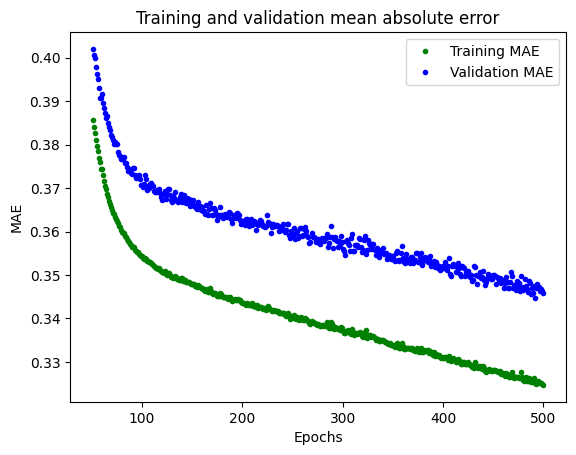

In [44]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Deze grafiek van _gemiddelde absolute fout_ vertelt een ander verhaal. We kunnen zien dat trainings gegevens consistent minder fouten vertonen dan validatie gegevens, wat betekent dat het netwerk mogelijks **overfit** is, of de trainingsgegevens zo goed heeft geleerd dat het geen effectieve voorspellingen kan doen over nieuwe gegevens.

Bovendien zijn de `MAE` waarden behoorlijk hoog, op zijn best `~0,305`, wat betekent dat sommige voorspellingen van het model er minstens `30%` naast zitten. Een fout van `30%` betekent dat we nog ver verwijderd zijn van het nauwkeurig modelleren van de sinusgolf functie.

#### Overfitting

Overfitting in een neuraal netwerk verwijst naar een situatie waarin het model de trainingsgegevens te goed heeft geleerd en te complex is geworden, zodat het begint te passen bij de ruis in de gegevens in plaats van bij het onderliggende patroon. Dit resulteert in slechte generalisatieprestaties, wat betekent dat het model goed presteert op de trainingsgegevens, maar slecht op nieuwe, ongeziene gegevens.

<!--
MSE vs MAE
In summary, MSE and MAE are both measures of the difference between the predictions and actual values, with MSE emphasizing larger errors and MAE providing a more robust measurement. The choice of loss function depends on the nature of the problem and the desired trade-off between sensitivity to larger errors and robustness to outliers.
-->

#### 3. Echte waarden versus voorspelde waarden

Laten we, om meer inzicht te krijgen in wat er gebeurt, de voorspellingen vergelijken met de testdataset die we eerder opzij hebben gezet:

7/7 [==============================] - 0s 1ms/step


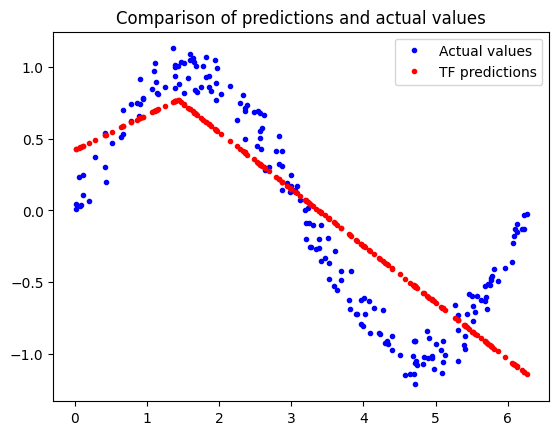

In [45]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model_1.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model_1.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

Slecht nieuws. De grafiek maakt duidelijk dat ons netwerk geleerd heeft om de sinusfunctie zeer beperkt te benaderen.

De rigiditeit van deze fit suggereert dat het model niet genoeg capaciteit heeft om de volledige complexiteit van de sinusgolf functie te leren. Door ons model groter te maken, zouden we de prestaties ervan moeten kunnen verbeteren.

Merk op dat dit net het omgekeerde is van een overfit, waar het model te complex is. Nu aangezien we maar 1 hidden layer hebben, is de kans wel heel klein dat we met een overfit zitten.

## Trainen van een groter model

Door extra layers en neuronen toe te voegen kan je een model groter maken en krijgt het dus meer capaciteit om te leren.

### 1. Maken van een groter model

Om ons model groter te maken gaan we een extra layer toevoegen na de originele hidden layer. Ook gaan we beide layers uit 16 neuronen laten bestaan in plaats van 8.

TODO: Figuur van netwerk

Merk wel op dat dit er zal voor zorgen dat het trainingsproces meer tijd in beslag zal nemen en dat ons uiteindelijk model ook meer geheugen zal nodig hebben.

In [46]:
model = tf.keras.Sequential(name="larger-model")

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,), name="hidden-layer-0"))

# The new second and third layer will help the network learn more complex representations
model.add(keras.layers.Dense(16, activation='relu', name="hidden-layer-1"))

# Final layer is a single neuron, since we want to output a single value
model.add(keras.layers.Dense(1, name="output-layer"))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

# Output some information about the model
model.summary()

Model: "larger-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden-layer-0 (Dense)      (None, 16)                32        
                                                                 
 hidden-layer-1 (Dense)      (None, 16)                272       
                                                                 
 output-layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


### 2. Trainen van het groter model

Laat ons vervolgens ook opnieuw dit model trainen.

**Opgelet! Als je onderstaande code om de een of andere reden nog eens zou uitvoeren, dan dien je bovenstaande code ook eerst opnieuw uit te voeren!**

In [47]:
# Train the model
history = model.fit(x_train, y_train, epochs=500, batch_size=64,
                    validation_data=(x_validate, y_validate))

# Save the model to disk
model.save(MODEL_TF)

Epoch 1/500
10/10 [==============================] - 1s 18ms/step - loss: 0.6581 - mae: 0.7205 - val_loss: 0.5302 - val_mae: 0.6522
Epoch 2/500
10/10 [==============================] - 0s 8ms/step - loss: 0.4636 - mae: 0.5985 - val_loss: 0.4630 - val_mae: 0.5866
Epoch 3/500
10/10 [==============================] - 0s 7ms/step - loss: 0.4374 - mae: 0.5597 - val_loss: 0.4439 - val_mae: 0.5699
Epoch 4/500
10/10 [==============================] - 0s 7ms/step - loss: 0.4157 - mae: 0.5424 - val_loss: 0.4123 - val_mae: 0.5531
Epoch 5/500
10/10 [==============================] - 0s 8ms/step - loss: 0.3836 - mae: 0.5288 - val_loss: 0.3863 - val_mae: 0.5390
Epoch 6/500
10/10 [==============================] - 0s 9ms/step - loss: 0.3577 - mae: 0.5113 - val_loss: 0.3590 - val_mae: 0.5191
Epoch 7/500
10/10 [==============================] - 0s 7ms/step - loss: 0.3331 - mae: 0.4913 - val_loss: 0.3355 - val_mae: 0.5037
Epoch 8/500
10/10 [==============================] - 0s 7ms/step - loss: 0.3109 - 

INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


### 3. Grafiek van de statistieken

Elke training epoch drukt het model het verlies en de gemiddelde absolute fout af voor training en validatie. U kunt dit lezen in de uitvoer hierboven (merk op dat uw exacte cijfers kunnen verschillen):

```
Epoch 500/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0117 - mae: 0.0870 - val_loss: 0.0111 - val_mae: 0.0848
```

Je kan zien dat we al een enorme verbetering hebben

- de `validation loss` is gedaald van `0,15` naar `0,01`
- de `validatie MAE` is gedaald van `0,33` naar `0,08`

De volgende cel zal dezelfde grafieken afdrukken die we gebruikten om ons oorspronkelijke model te evalueren, maar met onze nieuwe trainingsgeschiedenis

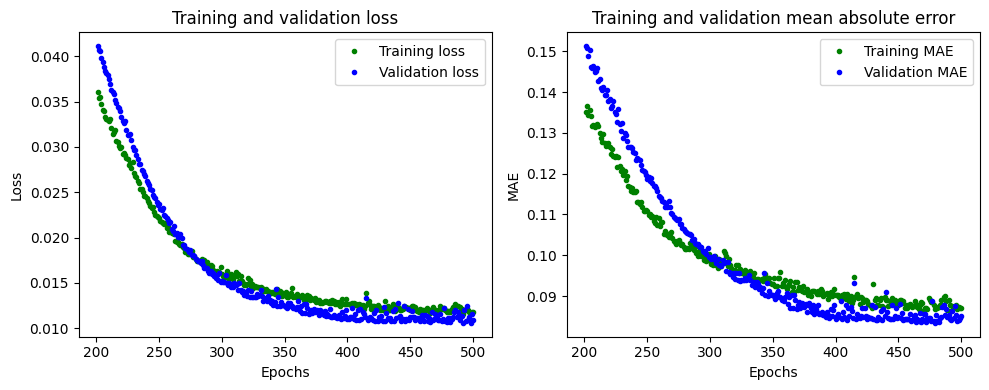

In [51]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 200

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

Dit zijn mooie resultaten. Uit deze grafieken kunnen we verschillende positieve dingen zien:

* De algemene `loss` en `MAE` zijn veel beter dan ons vorige netwerk
* Metrics zijn beter voor validatie dan voor training, wat betekent dat het netwerk niet overfitt is

De reden dat de statistieken voor validatie beter zijn dan die voor training, is dat validatiestatistieken worden berekend aan het einde van elke *epoch*, terwijl trainingsstatistieken gedurende de hele trainingsperiode worden berekend, dus validatie vindt plaats op een model dat iets langer is getraind.

Dit alles betekent dat ons netwerk goed lijkt te presteren. Laten we ter bevestiging de voorspellingen vergelijken met de test dataset die we eerder opzij hebben gezet:

7/7 [==============================] - 0s 1ms/step


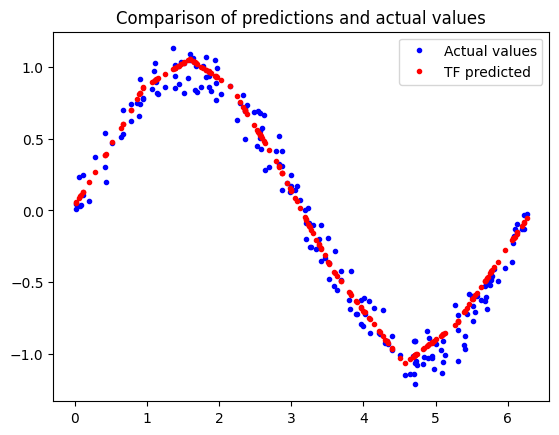

In [52]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

Veel beter. De voorspellingen komen visueel vrij goed overeen met onze gegevens.

Het model is niet perfect. De voorspellingen vormen geen vloeiende sinuscurve. De lijn is bijvoorbeeld bijna recht als `x` tussen `2,5` en `4,5` ligt. Als we verder zouden willen gaan, zouden we kunnen proberen de capaciteit van het model verder te vergroten, misschien door enkele technieken te gebruiken om overfitting te voorkomen.

Een belangrijk onderdeel van machine learning is echter **weten wanneer te stoppen**. Dit model is goed genoeg voor onze use case - namelijk om sommige LED's in een aangenaam patroon te laten knipperen.

## Genereren van een TensorFlow Lite model

Onze volgende stappen bestaan eruit om een model te genereren dat we op de microcontroller kunnen runnen. Hiervoor moeten we ons TensorFlow model omvormen naar een TensorFlow Lite model. Natuurlijk moeten we het dan ook nog omzetten in code.

### 1. Genereren van een Model met en zonder kwantisatie

We hebben nu een acceptabel nauwkeurig model. We gebruiken de [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) om het model om te zetten in een speciaal, ruimtebesparend formaat voor gebruik op devices met beperkte geheugencapaciteit.

Aangezien dit model op een microcontroller wordt ingezet, willen we dat het zo klein mogelijk is. Een techniek om de grootte van een model te verkleinen, wordt **[kwantisatie](https://www.tensorflow.org/lite/performance/post_training_quantization)** (quantization) genoemd. Het vermindert de precisie van de gewichten van het model, en mogelijk ook de activeringen (uitvoer van elke laag), wat geheugen bespaart, vaak zonder veel invloed op de nauwkeurigheid te hebben. Gekwantiseerde modellen werken ook sneller, omdat de vereiste berekeningen eenvoudiger zijn (gehele getallen versus komma getallen).

In de volgende sectie gaan we het model twee keer converteren: één keer met kwantisatie, één keer zonder.

In [53]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

2023-02-10 08:15:43.533693: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-02-10 08:15:43.533725: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-02-10 08:15:43.534876: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: models/model
2023-02-10 08:15:43.535909: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-02-10 08:15:43.535927: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: models/model
2023-02-10 08:15:43.538448: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-02-10 08:15:43.539267: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-02-10 08:15:43.579591: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: models/model
2023-02-10 08:15:43

2800

### 2. Vergelijking van de performantie van beide modellen

Om te bewijzen dat deze modellen nauwkeurig zijn, zelfs na conversie en kwantisatie, zullen we hun voorspellingen en verlies vergelijken met onze testdataset.

<!-- We define the `predict` (for predictions) and `evaluate` (for loss) functions for TFLite models. *Note: These are already included in a TF model, but not in  a TFLite model.* -->

In [54]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model,
                                    experimental_op_resolver_type=tf.lite.experimental.OpResolverType.BUILTIN_REF)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  
  # Invoke the interpreter
  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss

**1. Voorspellingen**

7/7 [==============================] - 0s 2ms/step


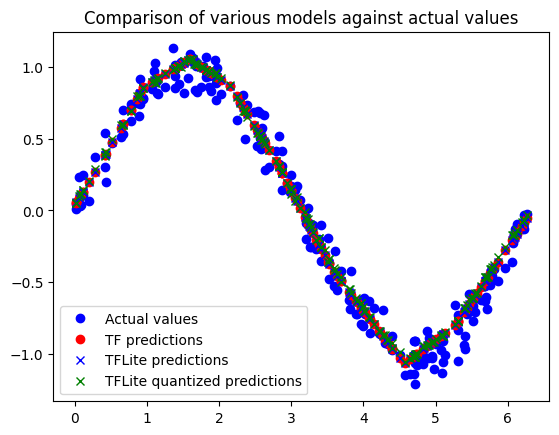

In [57]:
# Calculate predictions
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

# Compare predictions
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual values')
plt.plot(x_test, y_test_pred_tf, 'ro', label='TF predictions')
plt.plot(x_test, y_test_pred_no_quant_tflite, 'bx', label='TFLite predictions')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='TFLite quantized predictions')
plt.legend()
plt.show()

**2. Loss (MSE - Gemiddelde kwadratische fout)**

In [58]:
# Calculate loss
loss_tf, _ = model.evaluate(x_test, y_test, verbose=0)
loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
loss_tflite = evaluate_tflite(model_tflite, x_test, y_test)

# Compare loss
df = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf],
     ["TensorFlow Lite", loss_no_quant_tflite],
     ["TensorFlow Lite Quantized", loss_tflite]],
     columns = ["Model", "Loss/MSE"], index="Model").round(4)
df

,Loss/MSE
Model,
TensorFlow,0.0108
TensorFlow Lite,0.0108
TensorFlow Lite Quantized,0.0116


**3. Grootte in geheugen**

In [60]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow Lite,3304 bytes,(reduced by 792 bytes)
TensorFlow Lite Quantized,2800 bytes,(reduced by 504 bytes)


**Summary**

We kunnen aan de hand van de voorspellingen (grafiek) en de `loss` (tabel) zien dat het originele TF-model, het TFLite-model en het gekwantiseerde TFLite-model allemaal dicht genoeg bij elkaar liggen - ook al verschillen ze in grootte (tabel). Dit impliceert dat het gekwantiseerde (kleinste) model klaar is voor gebruik.

*Opmerking: het gekwantiseerde (integer) TFLite-model is slechts 500 bytes kleiner dan het originele (float) TFLite-model - een kleine verkleining! Dit komt doordat het model al zo klein is dat kwantisering minder effect heeft. Complexe modellen met meer gewicht kunnen tot 4x kleiner worden!*

## Genereren van een TensorFlow Lite model voor microcontrollers

Hier converteren we het gekwantiseerde model van TensorFlow Lite naar een C-bronbestand dat kan worden geladen door TensorFlow Lite voor microcontrollers.

In [64]:
# Install xxd if it is not available
# !apt update && apt -qq install xxd

# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}

# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0xa4, 0x00, 0x00, 0x00, 0xfc, 0x00, 0x00, 0x00, 0xb8, 0x03, 0x00, 0x00,
  0xc8, 0x03, 0x00, 0x00, 0x98, 0x0a, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x10, 0x00, 0x00, 0x00, 0x00, 0x00, 0x0a, 0x00,
  0x10, 0x00, 0x0c, 0x00, 0x08, 0x00, 0x04, 0x00, 0x0a, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x40, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x84, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x6f, 0x75, 0x74, 0x70,
  0x75, 0x74, 0x2d, 0x6c, 0x61, 0x79, 0x65, 0x72, 0x00, 0x00, 0x00, 0x00,
  0x01, 0x

## Implementeren op een microcontroller

Je kan nu de instructies volgen in de slides om het model te implementeren in de bijhorende demo applicatie. Zo kan het model worden uitgevoerd op de microcontroller.